In [4]:
import os
import argparse
import logging
import sys
from typing import List
from dpu_utils.utils.richpath import RichPath

import torch
from tqdm import tqdm
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [2]:
from fs_mol.data import FSMolDataset
from fs_mol.models.abstract_torch_fsmol_model import resolve_starting_model_file
from fs_mol.models.protonet import PrototypicalNetwork
from fs_mol.utils.protonet_utils import (
    PrototypicalNetworkTrainer,
    evaluate_protonet_model,
)
from fs_mol.utils.test_utils import add_eval_cli_args, set_up_test_run


In [ ]:
'''
parser = argparse.ArgumentParser(
        description="Test a Prototypical Network model on molecules.",)


parser.add_argument(
        "TRAINED_MODEL",
        type=str,
        required=False,
        help="File to load model from (determines model architecture).",
        default='checkpoints/PN-Support64_best_validation.pt'
    )

add_eval_cli_args(parser)

parser.add_argument(
    "--batch-size",
    type=int,
    default=320,
    help="Maximum batch size to allow when running through inference on model.",
)
    
parser.add_argument(
    "--use-fresh-param-init",
    action="store_true",
    help="Do not use trained weights, but start from a fresh, random initialisation.",
)

args = parser.parse_args()
'''

In [3]:
config = {'TRAINED_MODEL': 'checkpoints/PN-Support64_best_validation.pt'}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# This just return the path to the model file. If the model checkpoint is available, it 
# will be the corresponding path. Otherwise, it creates a new model pickle file and returns the path
# to that file.
model_weights_file = resolve_starting_model_file(
    model_file=config['TRAINED_MODEL'],
    model_cls=PrototypicalNetworkTrainer,
    out_dir='tmp/results',
    use_fresh_param_init=False,
    device=device,
)

Device: cuda


In [5]:
model = PrototypicalNetworkTrainer.build_from_model_file(
    model_weights_file,
    device=device,
)

In [9]:
model.__class__.__name__

'PrototypicalNetworkTrainer'

In [3]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))

# This will create a list of all tasks in the test tasks. Each task contains `MolculeDatapoint` objects
test_tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    test_tasks.append(task)

157it [00:01, 78.85it/s] 


In [4]:
from fs_mol.data import FSMolDataset, DataFold
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))

# This will create a list of all tasks in the test tasks. Each task contains `MolculeDatapoint` objects
a = []
# next line will create iterable object that will iterate over all tasks in the test dataset
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    a.append(task)

157it [00:02, 69.47it/s] 


In [9]:
sum([item.name == a[i].name for i, item in enumerate(test_tasks)])

11

In [11]:
train_tasks = []
train_task_iterable = dataset.get_task_reading_iterable(DataFold.TRAIN)
for task in tqdm(iter(train_task_iterable)):
    train_tasks.append(task)

4938it [00:13, 353.30it/s]


In [9]:
import torch
import numpy as np

support_features = torch.Tensor(np.array([item.fingerprint for item in test_tasks[0].samples]))
support_labels = torch.Tensor(np.array([item.bool_label for item in test_tasks[0].samples]))

In [10]:
support_features.shape

torch.Size([187, 2048])

In [12]:
# `compute_class_prototypes` requires two arguments: the support features and the support labels
# The support features are the features of the support set
# The support labels are the labels of the support set

prototypes = model._compute_class_prototypes(support_features, support_labels)

In [52]:
def compute_prototype(task) -> torch.Tensor:
    support_features = torch.Tensor(np.array([item.fingerprint for item in task.samples]))
    support_labels = torch.Tensor(np.array([item.bool_label for item in task.samples]))
    prototypes = model._compute_class_prototypes(support_features, support_labels)
    return prototypes

In [28]:
test_prototypes = [compute_prototype(task) for task in tasks]

In [29]:
train_prototypes = [compute_prototype(task) for task in train_tasks]

In [30]:
print(len(test_prototypes))
print(len(train_prototypes))

157
4938


In [31]:
neg_test_prototypes = torch.stack([prototypes[0] for prototypes in test_prototypes], dim=0)
pos_test_prototypes = torch.stack([prototypes[1] for prototypes in test_prototypes], dim=0)

neg_train_prototypes = torch.stack([prototypes[0] for prototypes in train_prototypes], dim=0)
pos_train_prototypes = torch.stack([prototypes[1] for prototypes in train_prototypes], dim=0)

In [33]:
print(neg_test_prototypes.shape)
print(pos_test_prototypes.shape)
print(neg_train_prototypes.shape)
print(pos_train_prototypes.shape)

torch.Size([157, 2048])
torch.Size([157, 2048])
torch.Size([4938, 2048])
torch.Size([4938, 2048])


In [31]:
labels = [0] * len(pos_train_prototypes) + [1] * len(pos_test_prototypes)

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)

def visualize_tsne(dataset: torch.Tensor):
    """Visualizes the t-SNE embedding of the given dataset.
    
    dataset: torch.Tensor of shape (N, D) where N is the number of samples and D is the dimension of the embedding.
    """
    labels_dict = {0: "Train", 1: "Test"}
    labels_leg = [labels_dict[item] for item in labels]
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    tsne_embedding = tsne.fit_transform(dataset.detach().numpy())

    size_map = [item*10 + 12 for item in labels]

    df = pd.DataFrame()
    df["y"] = labels
    df["comp-1"] = tsne_embedding[:,0]
    df["comp-2"] = tsne_embedding[:,1]

    _, ax = plt.subplots(1, 1, figsize=(15, 15))

    """
    sns.scatterplot(ax=ax, x="Component_1", y="Component_2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 2),
                    data=df).set(title="FS-MOL T-SNE projection of Protein/Task ESM Embedding")
    """
    ax.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], s=size_map, c=labels, cmap='Paired')
    ax.legend([labels_leg[i] for i in range(3)])
    ax.set_title("FS-Mol T-SNE Projection of Chemical Space Embedding")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    plt.show()

/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5095 samples in 0.005s...
[t-SNE] Computed neighbors for 5095 samples in 0.823s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5095
[t-SNE] Computed conditional probabilities for sample 2000 / 5095
[t-SNE] Computed conditional probabilities for sample 3000 / 5095
[t-SNE] Computed conditional probabilities for sample 4000 / 5095
[t-SNE] Computed conditional probabilities for sample 5000 / 5095
[t-SNE] Computed conditional probabilities for sample 5095 / 5095
[t-SNE] Mean sigma: 0.468544
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.098686
[t-SNE] KL divergence after 1000 iterations: 1.873955


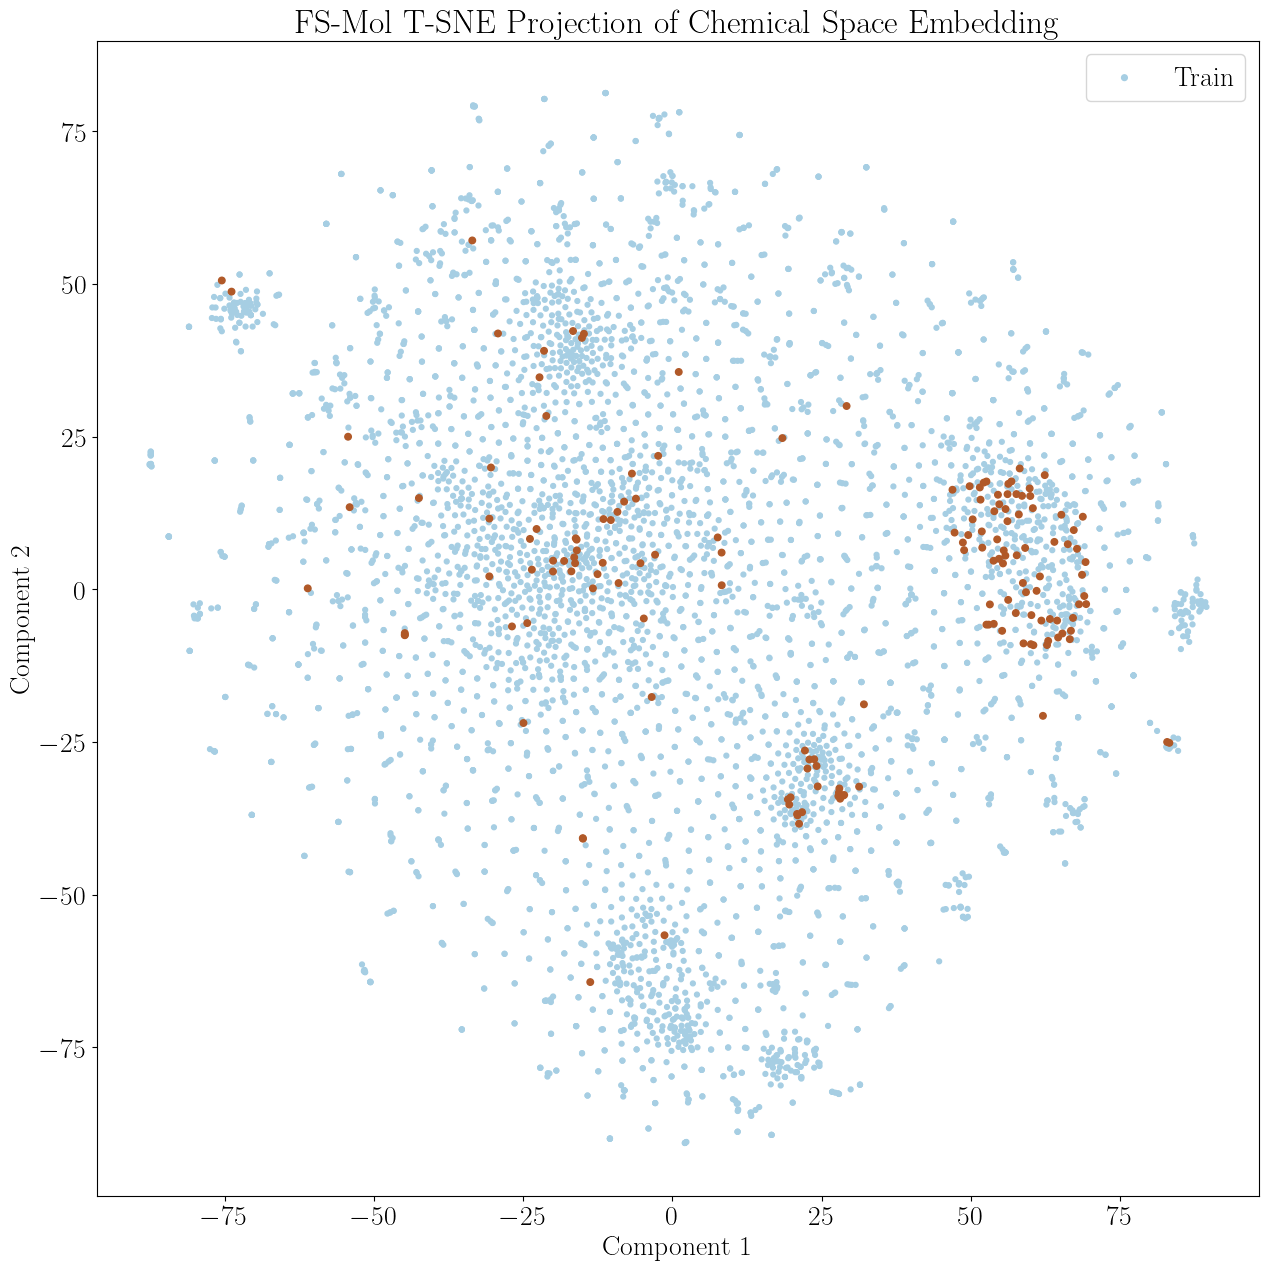

In [34]:
whole_pos_prototypes = torch.cat((neg_train_prototypes, neg_test_prototypes), 0)
visualize_tsne(whole_pos_prototypes)

In [ ]:
evaluate_protonet_model(
    model,
    dataset,
    support_sizes=[16],
    num_samples=1,
    seed=42,
    batch_size=32,
    save_dir=save_dir,
)

In [117]:
from fs_mol.data.fsmol_task import FSMolTaskSample

task_sample = FSMolTaskSample(tasks[0].name, [], [], tasks[0].samples)

In [118]:
from fs_mol.data.protonet import (
    ProtoNetBatch,
    get_protonet_task_sample_iterable,
    get_protonet_batcher,
    task_sample_to_pn_task_sample,
)
from fs_mol.utils.torch_utils import torchify

In [119]:
batcher = get_protonet_batcher(max_num_graphs=320)

In [120]:
pn_task_sample = torchify(
    task_sample_to_pn_task_sample(task_sample, batcher), device=model.device
)

IndexError: list index out of range

In [110]:
pn_task_sample.batch_labels

[]

## Extracting datamol representation for all the tasks

In [13]:
import pandas as pd
import datamol as dm
from molfeat.calc import FPCalculator
from molfeat.trans import MoleculeTransformer
from molfeat.store.modelstore import ModelStore

In [14]:
from molfeat.calc import FP_FUNCS
FP_FUNCS.keys()

dict_keys(['maccs', 'avalon', 'ecfp', 'fcfp', 'topological', 'atompair', 'rdkit', 'pattern', 'layered', 'map4', 'secfp', 'erg', 'estate', 'avalon-count', 'rdkit-count', 'ecfp-count', 'fcfp-count', 'topological-count', 'atompair-count'])

In [ ]:
# List all available featurizers
store = ModelStore()
store.available_models

In [42]:
calc = FPCalculator("ecfp")
transformer = MoleculeTransformer(calc, n_jobs=32)

In [145]:
from molfeat.trans.pretrained import GraphormerTransformer
from molfeat.trans.pretrained.hf_transformers import PretrainedHFTransformer

#transformer = GraphormerTransformer(kind='pcqm4mv2_graphormer_base', dtype=float)
transformer = PretrainedHFTransformer(kind='ChemBERTa-77M-MTR', notation='smiles', dtype=float, n_jobs=128)

In [106]:
from molfeat.trans.fp import FPVecTransformer
transformer = FPVecTransformer(kind='desc2D', dtype=float, n_jobs=32)

In [98]:
transformer = MoleculeTransformer(featurizer='mordred', dtype=float, n_jobs=32)

In [46]:
smiles = [item.smiles for item in test_tasks[0].samples]
labels = [item.bool_label for item in test_tasks[0].samples]

In [26]:
mol_trans = transformer(smiles)

In [18]:
import numpy as np
import torch

In [148]:
def compute_prototype_datamol(task, trans: MoleculeTransformer) -> torch.Tensor:
    support_smiles = [item.smiles for item in task.samples]
    support_features = torch.Tensor(np.array(trans(support_smiles)))
    support_labels = torch.Tensor(np.array([item.bool_label for item in task.samples]))
    prototypes = model._compute_class_prototypes(support_features, support_labels)
    return prototypes

In [149]:
test_prototypes =  [compute_prototype_datamol(task, transformer) for task in tqdm(test_tasks)]

  0%|          | 0/157 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 157/157 [03:02<00:00,  1.16s/it]


In [152]:
train_prototypes = [compute_prototype_datamol(task, transformer) for task in tqdm(train_tasks)]

  0%|          | 0/4938 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

100%|██████████| 4938/4938 [21:15<00:00,  3.87it/s]  


In [153]:
neg_test_prototypes = torch.stack([prototypes[0] for prototypes in test_prototypes], dim=0)
pos_test_prototypes = torch.stack([prototypes[1] for prototypes in test_prototypes], dim=0)

neg_train_prototypes = torch.stack([prototypes[0] for prototypes in train_prototypes], dim=0)
pos_train_prototypes = torch.stack([prototypes[1] for prototypes in train_prototypes], dim=0)

In [140]:
neg_train_prototypes1 = neg_train_prototypes[~torch.any(neg_train_prototypes.isnan(),dim=1)]

In [161]:
import pickle
path_to_save_embedding = 'train/embedding/ChemBERTa-77M-MTR_neg.pkl'
path_to_save_embedding = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding)
with open(path_to_save_embedding, 'wb') as f:
    pickle.dump(neg_train_prototypes, f)
    

In [2]:
import pickle
path_to_save_embedding_train = 'train/embedding/pcqm4mv2_graphormer_base_pos.pkl'
path_to_save_embedding_train = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding_train)

with open(path_to_save_embedding_train, 'rb') as f:
    x = pickle.load(f)

path_to_save_embedding_test = 'test/embedding/pcqm4mv2_graphormer_base_pos.pkl'
path_to_save_embedding_test = os.path.join(FS_MOL_DATASET_PATH, path_to_save_embedding_test)

with open(path_to_save_embedding_test, 'rb') as f:
    y = pickle.load(f)


In [3]:
pos_train_prototypes = torch.stack(list(x.values()), dim=0)
pos_test_prototypes = torch.stack(list(y.values()), dim=0)

In [4]:
labels = [0] * len(pos_train_prototypes) + [1] * len(pos_test_prototypes)

/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vscholz/miniconda3/envs/datamol/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5095 samples in 0.002s...
[t-SNE] Computed neighbors for 5095 samples in 0.767s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5095
[t-SNE] Computed conditional probabilities for sample 2000 / 5095
[t-SNE] Computed conditional probabilities for sample 3000 / 5095
[t-SNE] Computed conditional probabilities for sample 4000 / 5095
[t-SNE] Computed conditional probabilities for sample 5000 / 5095
[t-SNE] Computed conditional probabilities for sample 5095 / 5095
[t-SNE] Mean sigma: 0.517092
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.549538
[t-SNE] KL divergence after 1000 iterations: 1.377212


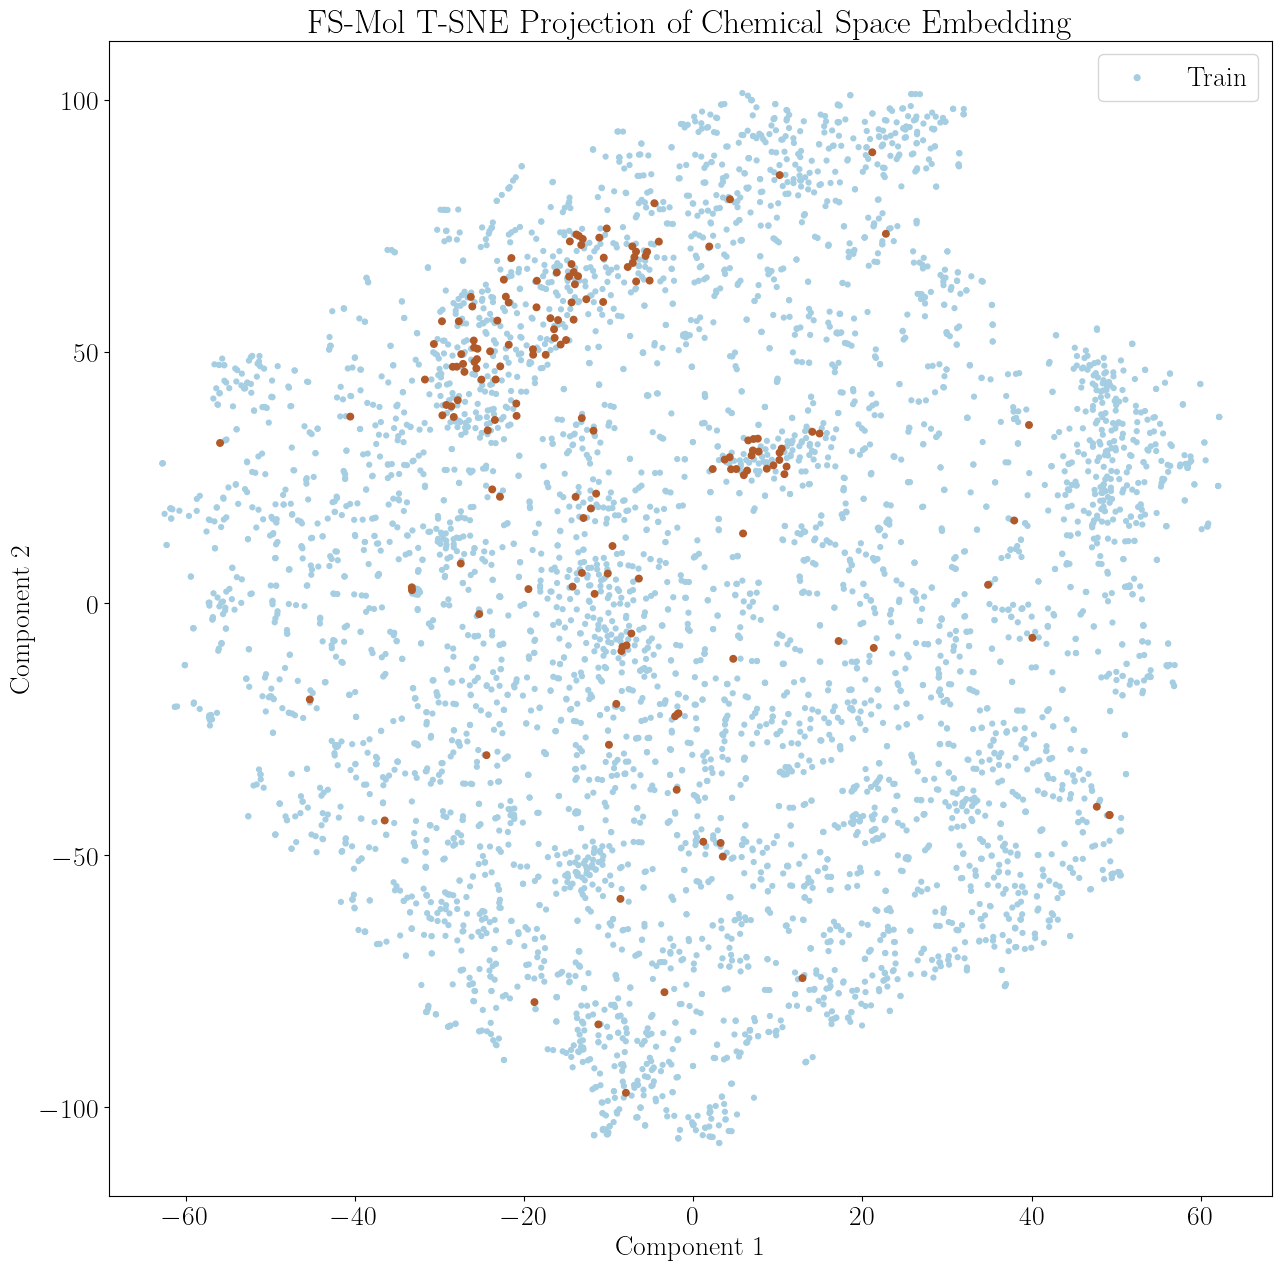

In [7]:
whole_pos_prototypes = torch.cat((pos_train_prototypes, pos_test_prototypes), 0)
visualize_tsne(whole_pos_prototypes)

In [128]:
sum([len(item)==214 for item in pos_test_prototypes])

157

In [129]:
len(pos_train_prototypes)

4938

In [75]:
with open('./datasets/train/embedding/ecfp_neg.pkl', 'rb') as f:
    x2 = pickle.load(f)

In [91]:
x =  [task.name for task in train_tasks]
y = [len(task.samples) for task in train_tasks]

In [92]:
import pandas as pd
df = pd.DataFrame({'task_name': x, 'num_samples': y})
df.to_csv('./datasets/train/embedding/metadata.csv', index=False)

array([[<AxesSubplot:title={'center':'num_samples'}>]], dtype=object)

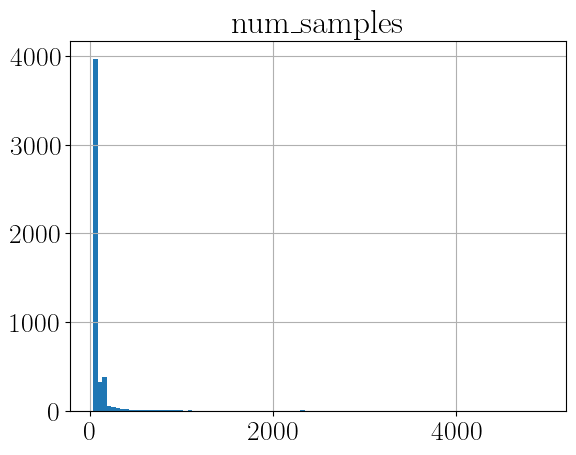

In [97]:
df.hist(bins=100)

## Visualizing task hardness based on different prototypes representation

In [45]:
## Importing and Setting visulization parameters and reading the data

%matplotlib inline

PATH_TO_HARDNESS = os.path.join(FS_MOL_DATASET_PATH, 'test/hardness/desc2D_pos_norm2_0.1.csv')
hardness_df = pd.read_csv(PATH_TO_HARDNESS)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"

plt.rcParams.update(
    {
        "font.size": 20,
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
    }
)



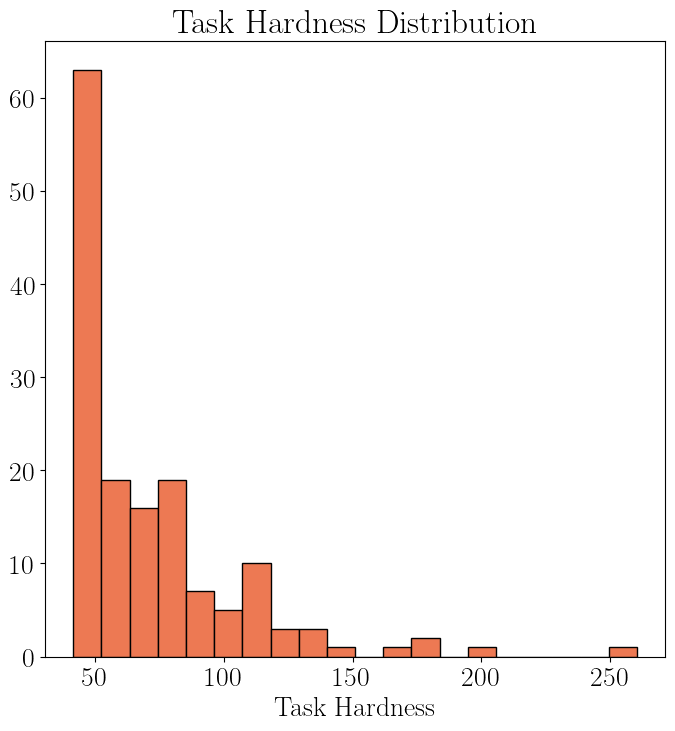

In [46]:
# Visualizing the Hardness Distribution
_, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.hist(hardness_df['hardness'], bins=20, color=light_color, edgecolor=dark_color)
ax.set_title("Task Hardness Distribution")
ax.set_xlabel("Task Hardness")
plt.show()

In [55]:
evaluation_output_directory = os.path.join(FS_MOL_CHECKOUT_PATH, "outputs", "FSMol_Eval_ProtoNet_2023-02-15_12-21-54")
output_results = pd.read_csv(os.path.join(evaluation_output_directory, "summary", "ProtoNet_summary_num_train_requested_128.csv"))
hard = pd.read_csv(PATH_TO_HARDNESS)
hard.columns = ['assay', 'hardness']

-0.019908996378977244
-0.41507778529836264


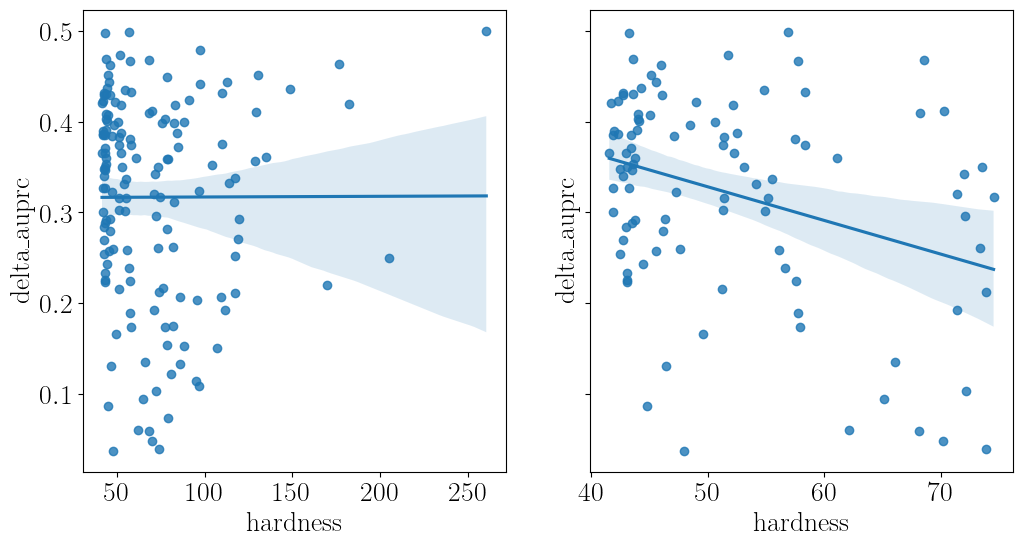

In [66]:
# Visualizing the Hardness vs Performance (Caclulated correlation)
import seaborn as sns
x = pd.merge(output_results[['assay', 'delta_auprc', 'roc_auc']], hard, on="assay")
print(x['hardness'].corr( x['roc_auc']))

z = x[x['hardness'] < 75]
print(z['hardness'].corr( z['roc_auc']))

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))
sns.regplot(x="hardness", y="delta_auprc",data=x, ax=ax1)
sns.regplot(x="hardness", y="delta_auprc",data=z, ax=ax2)
#ax[0].set(xlabel='chemical space hardness')
#ax[1].set(xlabel='chemical space hardness')
plt.show()